In [1]:
import sys
sys.path.append('../')

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from helpers_mom6.collection_of_experiments import CollectionOfExperiments
from helpers.plot_helpers import *
from helpers_mom6.computational_tools import remesh, select_LatLon, Lk_error, x_coord, y_coord, gaussian_remesh
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import os
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import hvplot.xarray
import hvplot
hvplot.output(widget_location='bottom')

In [520]:
ds = CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Feb2022/bare', additional_subfolder='output')

In [521]:
directory = "/scratch/pp2681/mom6/Apr2023/generalization"
for name in os.listdir(directory):
    ds += CollectionOfExperiments.init_folder(os.path.join(directory,name), additional_subfolder='output', prefix=name)

In [522]:
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2023/GZ21_results', additional_subfolder='')

In [523]:
directory = "/scratch/pp2681/mom6/CM26_Double_Gyre/generalization"
for name in os.listdir(directory):
    ds += CollectionOfExperiments.init_folder(os.path.join(directory,name), additional_subfolder='output', prefix=name)

In [524]:
len(ds.exps)

589

In [525]:
for exp in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']:
    ds.remesh('R64', exp)

Experiment R64 coarsegrained to R2 is created. Its identificator=R64_R2
Experiment R64 coarsegrained to R3 is created. Its identificator=R64_R3
Experiment R64 coarsegrained to R4 is created. Its identificator=R64_R4
Experiment R64 coarsegrained to R5 is created. Its identificator=R64_R5
Experiment R64 coarsegrained to R6 is created. Its identificator=R64_R6
Experiment R64 coarsegrained to R7 is created. Its identificator=R64_R7
Experiment R64 coarsegrained to R8 is created. Its identificator=R64_R8


# Generalization

In [7]:
def sample_ssh(exp, target):
    
    sample = []
    for year_start in [5, 10, 15]:
        year_end = year_start + 5
        idx = slice(365*year_start, 365*year_end)
        sample.append(
            Lk_error(ds[exp].ea.isel(zi=0).sel(Time=idx).mean('Time'), ds[target].ssh_mean)[0]
        )
    return xr.DataArray(sample, dims='sample')

In [8]:
def error_ssh(exp, target):
    return Lk_error(ds[exp].ssh_mean,ds[target].ssh_mean)[0]

In [9]:
def sample_KE(exp, target=None):
    sample = []
    for year_start in [5, 10, 15]:
        year_end = year_start + 5
        idx = slice(365*year_start, 365*year_end)
        u = ds[exp].u.sel(Time=idx)
        v = ds[exp].v.sel(Time=idx)
        h = ds[exp].h.sel(Time=idx)

        KE = 1e-15 * ds[exp].KE_joul(u, v, h).mean('Time').sum()
        sample.append(KE)
    return xr.DataArray(sample, dims='sample')

In [10]:
def KE(exp, target=None):
    return 1e-15 * (ds[exp].MKE_joul + ds[exp].EKE_joul).sum('zl').values

In [11]:
def sample_APE(exp, target=None):
    sample = []
    for year_start in [5, 10, 15]:
        year_end = year_start + 5
        idx = slice(365*year_start, 365*year_end)
        e = ds[exp].e.sel(Time=idx)
        APE = 1e-15 * (
            ds[exp].PE_joul(e).mean('Time').sum() + 
            ds[exp].PE_ssh(e).mean('Time').sum()
        )
        sample.append(APE)
    return xr.DataArray(sample, dims='sample')

In [12]:
def APE(exp, target=None):
    return 1e-15 * (ds[exp].MPE_joul + ds[exp].EPE_joul + ds[exp].MPE_ssh + ds[exp].EPE_ssh).values

In [13]:
def generalization_error(prefix='ZB-clean', fun=error_ssh, confs=['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8'], ZB=None):
    if ZB is None:
        ZB = sorted([float(exp.split('-')[-1]) for exp in ds.exps if f'{prefix}-R4' in exp])
        
    conf_list = []
    for i, conf in enumerate(confs):
        zb_list = []
        for j, zb in enumerate(ZB):
            try:
                error = fun(f'{prefix}-{conf}-ZB-{zb}', f'R64_{conf}')
            except:
                error = np.nan
            zb_list.append(error)
        if isinstance(zb_list[-1],xr.DataArray):
            zb_list = xr.concat(zb_list, dim='ZB')
        else:
            import pdb
            pdb.set_trace()
            zb_list = xr.DataArray(zb_list, dims='ZB')

        conf_list.append(zb_list)
    
    conf_list = xr.concat(conf_list, 'res')    
    conf_list['ZB'] = ZB
    return conf_list

# New plotter of APE/KE metrics

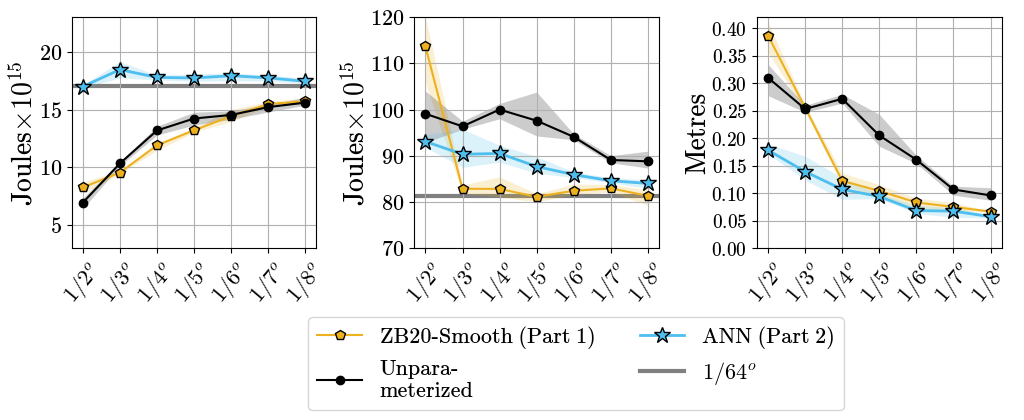

In [576]:
default_rcParams({'font.size': 16, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
plt.figure(figsize=(12,3))

yellow = [0.9290, 0.6940, 0.1250]
violet = [0.4940, 0.1840, 0.5560]
lightblue = [0.3010, 0.7450, 0.9330]

for row, fun in enumerate([sample_KE, sample_APE, sample_ssh]):
    plt.subplot(1,3,row+1)
    error = {}
    error['bare'] = xr.concat([fun(conf,f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    #error['ZB-clean'] = xr.concat([fun(f'ZB-clean-{conf}-ZB-0.4', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    error['ZB-Smooth'] = xr.concat([fun(f'ZB-Smooth-{conf}-ZB-1.0', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
#    error['ZB-Reynolds'] = xr.concat([fun(f'ZB-Reynolds-{conf}-ZB-2.0', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
#    error['Jansen-Held'] = xr.concat([fun(f'Jansen-Held-{conf}-ref', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
#    error['GZ'] = xr.concat([error['bare'].isel(res=0)*np.nan, error['bare'].isel(res=0)*np.nan] + [fun(f'{conf}_GZ-20YEAR', f'R64_{conf}') for conf in ['R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    error['ANN-SGS-KE'] = xr.concat([fun(f'ANN_CM26_grid_harmonic_ver3-{conf}-ZB-1.0-SGS-KE', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
        
    def plot_markers_with_filling(model='Jansen-Held', color='tab:red', marker='s', label=None, markersize=None, lw=None):
        error[model].mean('sample').plot(color=color, marker=marker, label=label, markersize=markersize, markeredgecolor='k', lw=lw)
        plt.fill_between(range(7), error[model].min('sample'), error[model].max('sample'), color=color, alpha=0.2, lw=0)
    
 #   plot_markers_with_filling('Jansen-Held', 'tab:red', 's', 'JH15', 5)
 #   plot_markers_with_filling('GZ', 'tab:green', 'D', 'GZ21', 5)
    #plot_markers_with_filling('ZB-clean', 'tab:blue', 'o', 'ZB')
    plot_markers_with_filling('ZB-Smooth', yellow, 'p', 'ZB20-Smooth (Part 1)', 7)
#    plot_markers_with_filling('ZB-Reynolds', violet, 'd', 'ZB20-Reynolds', 6)
    plot_markers_with_filling('bare', 'k', 'o', 'Unpara-\nmeterized', 6)
    plot_markers_with_filling('ANN-SGS-KE', lightblue, '*', 'ANN (Part 2)', 12, lw=2)
    
    plt.xticks([0,1,2,3,4,5,6], ['$1/2^o$', '$1/3^o$', '$1/4^o$', '$1/5^o$', '$1/6^o$', '$1/7^o$', '$1/8^o$'],rotation=50)    
    plt.grid()
    plt.xlabel('')
    if fun == sample_KE:
        yticks = np.arange(5,25,5)
        plt.ylabel('Joules$\\times10^{15}$', fontsize=20)
        plt.yticks(yticks)
        plt.ylim([3,23])
        plt.axhline(y=KE('R64'),color='gray', zorder=-1,lw=3)
        #plt.text(0.0, 17.5,'$1/64^o$', color='gray')
    if fun == sample_APE:
        yticks = np.arange(70,130,10)
        plt.ylabel('Joules$\\times10^{15}$', fontsize=20)
        plt.yticks(yticks)
        plt.ylim([min(yticks), max(yticks)])
        plt.axhline(y=APE('R64'),color='gray',zorder=-1,lw=3)
    
    if fun == sample_ssh:
        yticks = np.arange(0,0.45,0.05)
        plt.ylabel('Metres', fontsize=20)
        plt.yticks(yticks, fontsize=14)
        plt.ylim([0,0.42])

plt.gcf().align_ylabels()
plt.plot(np.nan,np.nan,'-',color='gray',lw=3,label='$1/64^o$')
plt.legend(ncol=2, bbox_to_anchor=(0.4,-0.25))

plt.savefig('../presentation/Metrics-ANN.pdf')

In [50]:
def plot(idx):
    ds.plot_RV(['R64'], ['$1/64^o, 1.5km$'], idx=idx)

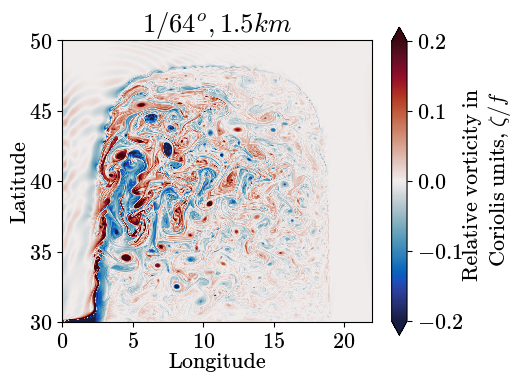

In [51]:
plot(119)

In [52]:
create_animation(plot, idx=range(119, 190), dpi=200, FPS=15, filename='../presentation/R64.gif')

Animation at FPS=15 will last for 4.733333333333333 seconds


# Animation of restoring of isopycnals

In [343]:
def psi(x,y,amp):
    '''
    Zeros on upper and lower boundaries, and one onthe interface
    '''
    y_interface = amp * np.cos(x/4)
    x_shape = 1
    if y < y_interface:
        return - amp * (y + 2) / (y_interface + 2.) * x_shape
    else:
        return - amp * (y - 2) / (y_interface - 2.) * x_shape

In [347]:
def psi_np(amp):
    x = np.linspace(0,np.pi*4,100)
    y = np.linspace(-2,2,100)
    X,Y = np.meshgrid(x,y)
    
    ny, nx = X.shape
    Psi = X * 0
    for j in range(ny):
        for i in range(nx):
            Psi[j,i] = psi(X[j,i],Y[j,i],amp)
    return X, Y, Psi

In [413]:
def uv_np(amp, dx = 1e-5, N=100):
    x = np.linspace(0,np.pi*4,N)
    y = np.linspace(-2,2,N)
    X,Y = np.meshgrid(x,y)
    
    ny, nx = X.shape
    u = X * 0
    v = X * 0
    for j in range(ny):
        for i in range(nx):
            x = X[j,i]
            y = Y[j,i]
            u[j,i] = - (psi(x,y+dx,amp) - psi(x,y-dx,amp)) / (2*dx)
            v[j,i] = + (psi(x+dx,y,amp) - psi(x-dx,y,amp)) / (2*dx)
    return X, Y, u, v

In [418]:
def plot(amp = 1):
    plt.figure(figsize=(10,4))
    x = np.linspace(0,np.pi*4,100)
    interface = amp * np.cos(x/4)
    plt.fill_between(x,-2*np.ones_like(x),interface)
    plt.plot(x,interface, 'k', lw=3)
    plt.fill_between(x,interface,2*np.ones_like(x), color='tab:green')
    plt.axis('off')
    plt.axhline(y=-2, color='k', lw=2)
    plt.axhline(y=2, color='k', lw=2)
    X,Y,u,v = uv_np(amp, N=10)
    plt.quiver(X,Y,u,v, color='white', scale=5)
    
    plt.text(x=0.1,y=-1.5, s='Lower\nfluid layer', fontsize=20, fontweight='bold')
    plt.text(x=0.1,y=1.1, s='Upper\nfluid layer', fontsize=20, fontweight='bold')
    
#    plt.contour(*psi_np(amp), colors='k')
    plt.gca().set_aspect(1)
    
    plt.xlim([0,np.pi*4])
    plt.ylim([-2.02,2.01])


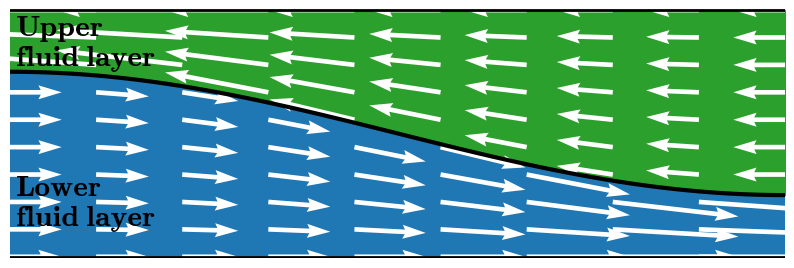

In [419]:
plot_idx = lambda idx: plot(1-idx/45)
plot_idx(0)

In [420]:
create_animation(plot_idx, range(45), 'interface_restoring.gif', deezering=False, FPS=15, dpi=150)

Animation at FPS=15 will last for 3.0 seconds


# Energy transfer simpler

In [421]:
FGR=2.5
ds.remesh('R64', 'R4', f'R64_R4_FGR{FGR}', operator= lambda x,y: gaussian_remesh(x,y,FGR=FGR))
for file in [f'/scratch/pp2681/mom6/R64_R4_FGR{FGR}-part1.nc', f'/scratch/pp2681/mom6/R64_R4_FGR{FGR}-part2.nc']:
    dataset = xr.open_dataset(file, decode_times=False)
    for key in dataset.keys():
        setattr(ds[f'R64_R4_FGR{FGR}'], key, dataset[key])

Experiment R64 coarsegrained to R4 is created. Its identificator=R64_R4_FGR2.5


In [428]:
ref = ds['R64_R4_FGR2.5']
SGS = ref.SGS_transfer
ZB_offline = ref.transfer(*ref.ZB_offline(amplitude=0.5)).compute()
ZB_smooth_offline = ref.transfer(*ref.ZB_offline(amplitude=1.0, Stress_iter=4)).compute()
ZB_reynolds_offline = ref.transfer(*ref.ZB_offline(amplitude=2.0, Stress_iter=4, HPF_iter=4)).compute()

In [429]:
Smagorinsky_offline = ref.transfer(*ref.Smagorinsky(Cs=0.06)).compute()

In [430]:
gz = xr.concat([xr.open_dataset('/scratch/pp2681/mom6/Apr2023/GZ_offline/GZ21_zl0.nc',
                decode_times=False), xr.open_dataset('/scratch/pp2681/mom6/Apr2023/GZ_offline/GZ21_zl1.nc',
                decode_times=False)], 'zl').rename({'time': 'Time'})
scaling = 0.7827
GZ_offline = ref.transfer(scaling * gz.S_x, scaling * gz.S_y).compute()

In [424]:
def compensated(sp):
    return sp * sp.freq_r

In [435]:
coarse = 'R4'
hires = 'R64'
hires_bar = 'R64_R4'
ZB = 'ZB-clean-R4-ZB-0.5'
JansenHeld = 'Jansen-Held-R4-ref';
ZB_smooth = 'ZB-Smooth-R4-ZB-1.0'
ZB_reynolds = 'ZB-Reynolds-R4-ZB-2.0'
GZ = 'R4_GZ-20YEAR'

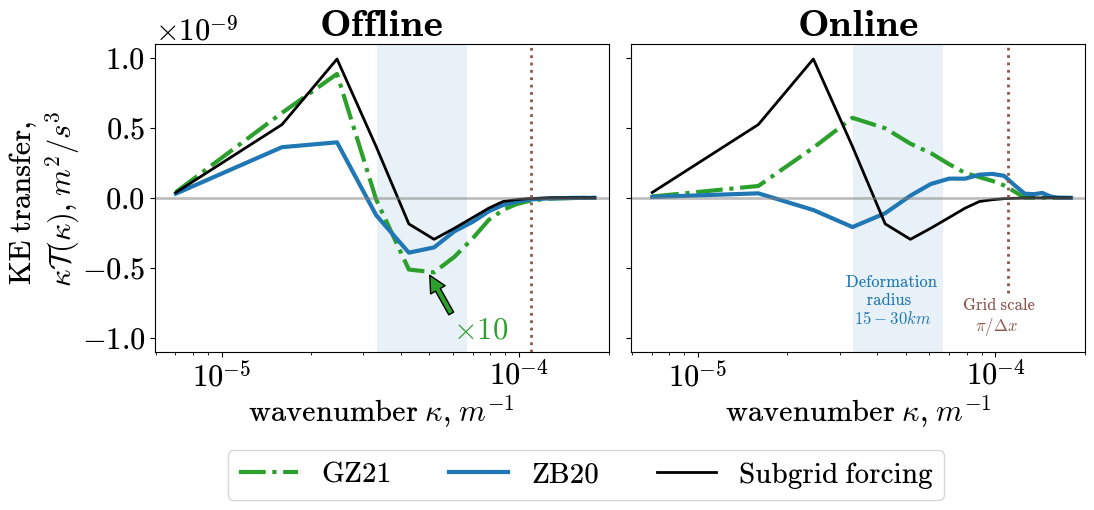

In [443]:
labels = ['ZB20', 'ZB20-Smooth', 'ZB20-Reynolds']
colors = ['tab:blue', yellow, violet]

default_rcParams({'font.size':22, 'figure.subplot.wspace': 0.05})
zl=0
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
compensated(GZ_offline*10).isel(zl=zl).plot(lw=3, color='tab:green', ls='-.')
compensated(ZB_offline).isel(zl=zl).plot(lw=3, color=colors[0])
#compensated(ZB_smooth_offline).isel(zl=zl).plot(lw=3, color=colors[1])
compensated(SGS).isel(zl=zl).plot(color='k', lw=2)
plt.axhline(y=0,color='gray', alpha=0.5, lw=2)
plt.xlabel('wavenumber $\kappa$, $m^{-1}$')
plt.ylabel('KE transfer, \n$\kappa \mathcal{T}(\kappa)$, $m^2/s^3$')
plt.title('Offline', fontweight='bold', y=1.)
Rd1 = 30000
Rd2 = 15000
plt.axvspan(1/Rd1, 1/Rd2, color='tab:blue', alpha=0.1, lw=0)
plt.ylim([-1.1e-9,1.1e-9])
plt.yticks(np.linspace(-1e-9,1e-9,5))
plt.xscale('log')
plt.axvline(x=1.1e-4, ls=':', color='tab:brown', lw=2)
plt.xlim([None, 2e-4])

plt.gca().annotate('$\\times 10$', color='tab:green', xy=(5e-5, -0.55e-9), xytext=(6e-5,-1e-9),
                arrowprops=dict(facecolor='tab:green', shrink=0.01))

plt.subplot(1,2,2)
lss = ['-','-','-']
#compensated(ds['Jansen-Held-R4-backscatter-data-ref'].JH_transfer).isel(zl=zl).plot(lw=3, label='JH15($\\nabla^2$)', color='tab:red', ls='--')
compensated(ds[GZ].GZ_transfer).isel(zl=zl).plot(lw=3, label='GZ21', color='tab:green', ls='-.')
for exp,label,color,ls in zip([ZB],labels,colors,lss):
    compensated(ds[exp].ZB_transfer).isel(zl=zl).plot(lw=3, label=label,color=color,ls=ls)
#compensated(ds['R4'].Model_transfer).isel(zl=zl).plot(lw=3, label='Smag($\\nabla^4$)', color=lightblue)
compensated(SGS).isel(zl=zl).plot(color='k', lw=2, label='Subgrid forcing')
plt.axhline(y=0,color='gray', alpha=0.5, lw=2)
plt.xlabel('wavenumber $\kappa$, $m^{-1}$')
plt.ylim([-1.1e-9,1.1e-9])
plt.yticks(np.linspace(-1e-9,1e-9,5), [None]*5)
plt.xscale('log')
plt.xlim([None, 2e-4])
plt.title('Online', fontweight='bold', y=1.)
plt.legend(bbox_to_anchor=(-0.1,-0.4), loc='center', ncol=3, fontsize=21)
plt.axvspan(1/Rd1, 1/Rd2, color='tab:blue', alpha=0.1, lw=0)
plt.text(3.15e-5,-0.9e-9,'Deformation \n     radius \n  $15-30km$', fontsize=12, color='tab:blue')
plt.axvline(x=1.1e-4, ls=':', color='tab:brown', ymin=0.19, lw=2)
plt.text(0.78e-4, -0.95e-9, 'Grid scale\n   $\\pi/\\Delta x$', fontsize=12, color='tab:brown')

plt.savefig('../presentation/KE_transfer.pdf')

# Animations of ANNs

In [559]:
default_rcParams({'font.size': 15})
def plot(idx=-1, ncols=2, zl=0):
    ds.plot_RV(['ANN_CM26-R8-ZB-1.0-Cs-0.00',
                'R64',
                'ANN_CM26_grid_harmonic_ver3-R8-ZB-1.0-Cs-0.0',
                'ANN_CM26_grid_harmonic_ver3-R4-ZB-1.0-Cs-0.0'
               ],
               ['$1/8^o$, ANN\nwithout constraint',
                '$1/64^o$',
                '$1/8^o$, ANN\nwith constraint',
                '$1/4^o$, ANN\nwith constraint'
               ],
                idx=idx, ncols=ncols, zl=zl)

In [563]:
default_rcParams({'font.size': 15})
def plot(idx=-1, ncols=4, zl=0):
    ds.plot_RV(['ANN_CM26-R8-ZB-1.0-Cs-0.00',
                'R64',
                'ANN_CM26_grid_harmonic_ver3-R8-ZB-1.0-Cs-0.0',
                'ANN_CM26_grid_harmonic_ver3-R4-ZB-1.0-Cs-0.0'
               ],
               ['$1/8^o$, ANN\nwithout constraint',
                '$1/64^o$',
                '$1/8^o$, ANN\nwith constraint',
                '$1/4^o$, ANN\nwith constraint'
               ],
                idx=idx, ncols=ncols, zl=zl)

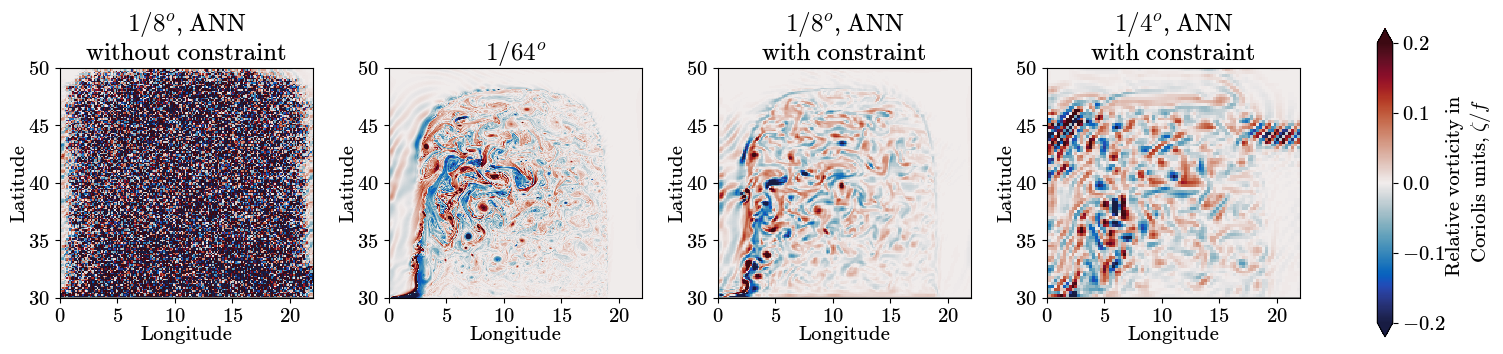

In [564]:
plot(-1)

In [571]:
default_rcParams({'font.size': 15})
def plot(idx=-1, ncols=3, zl=0):
    ds.plot_RV(['ANN_CM26-R8-ZB-1.0-Cs-0.00',
                'ANN_CM26_grid_harmonic_ver3-R4-ZB-1.0-Cs-0.0',
                'ANN_CM26_grid_harmonic_ver3-R4-ZB-1.0-SGS-KE'
               ],
               ['$1/4^o$, ANN\nwithout constraints',
                '$1/4^o$, ANN\nconstr. on short waves',
                '$1/4^o$, ANN\nconstr. on short waves \n+ SGS KE'
               ],
                idx=idx, ncols=ncols, zl=zl)

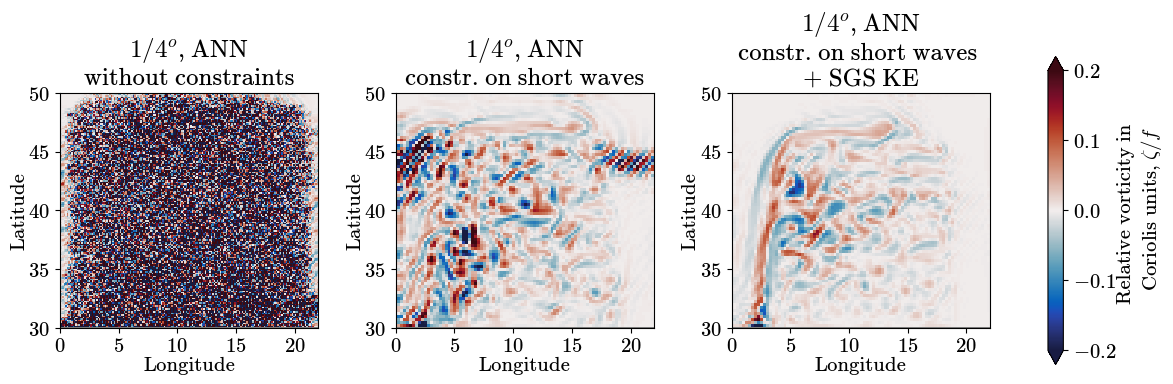

In [572]:
plot()

In [573]:
create_animation_ffmpeg(plot, range(243), 'ANN_two_constraints.mp4')

Native resolution of snapshots is used: 2342x772

Animation ANN_two_constraints.mp4 at FPS=18 will last for 13.5 seconds. The frames are saved to 
.ffmpeg/ANN_two_constraints



ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

# Fancy short wave

In [471]:
from helpers.cm26 import DatasetCM26
from helpers.selectors import plot, select_globe

In [463]:
ds = DatasetCM26()

In [506]:
batch = ds.split().coarsen(30)

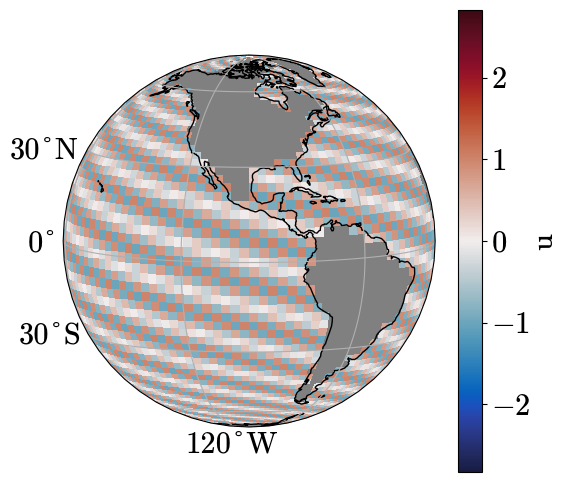

In [516]:
state = batch.state.sample_grid_harmonic('plane_wave')
plot(state.data.u, state.param.wet_u, selector=select_globe)
plt.savefig('../presentation/short_wave.pdf')

# NW2

In [2]:
import xarray as xr

In [3]:
import math
def x_coord(array):
    '''
    Returns horizontal coordinate, 'xq' or 'xh'
    as xarray
    '''
    try:
        coord = array.xq
    except:
        coord = array.xh
    return coord

def y_coord(array):
    '''
    Returns horizontal coordinate, 'yq' or 'yh'
    as xarray
    '''
    try:
        coord = array.yq
    except:
        coord = array.yh
    return coord

def remesh(input, target, fillna=True):
    '''
    Input and target should be xarrays of any type (u-array, v-array, q-array, h-array).
    Datasets are prohibited.
    Horizontal mesh of input changes according to horizontal mesh of target.
    Other dimensions are unchanged!

    If type of arrays is different:
        - Interpolation to correct points occurs
    If input is Hi-res:
        - Coarsening with integer grain and subsequent interpolation to correct mesh if needed
    if input is Lo-res:
        - Interpolation to Hi-res mesh occurs

    Input and output Nan values are treates as zeros (see "fillna")
    '''

    # Define coordinates
    x_input  = x_coord(input)
    y_input  = y_coord(input)
    x_target = x_coord(target)
    y_target = y_coord(target)

    # ratio of mesh steps
    ratiox = np.diff(x_target)[0] / np.diff(x_input)[0]
    ratiox = math.ceil(ratiox)

    ratioy = np.diff(y_target)[0] / np.diff(y_input)[0]
    ratioy = math.ceil(ratioy)
    
    # B.C.
    if fillna:
        result = input.fillna(0)
    else:
        result = input
    
    if (ratiox > 1 or ratioy > 1):
        # Coarsening; x_input.name returns 'xq' or 'xh'
        result = result.coarsen({x_input.name: ratiox, y_input.name: ratioy}, boundary='pad').mean()

    # Coordinate points could change after coarsegraining
    x_result = x_coord(result)
    y_result = y_coord(result)

    # Interpolate if needed
    if not x_result.equals(x_target) or not y_result.equals(y_target):
        result = result.interp({x_result.name: x_target, y_result.name: y_target})
        if fillna:
            result = result.fillna(0)

    # Remove unnecessary coordinates
    if x_target.name != x_input.name:
        result = result.drop_vars(x_input.name)
    if y_target.name != y_input.name:
        result = result.drop_vars(y_input.name)
    
    return result

In [11]:
files_R4 = [f'/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/bare/output/{file}' for file in ['snapshots_00023010.nc', 'snapshots_00024030.nc']]
files_smooth = [f'/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Smooth-filter-3D/output/{file}' for file in ['snapshots_00027030.nc', 'snapshots_00028020.nc']]
files_ann = [f'/scratch/pp2681/mom6/Neverworld2/simulations/R4-ANN/CM26_grid_harmonic_ver3-SGS-KE/0-29000-days/{file}' for file in ['snapshots_00027030.nc', 'snapshots_00028020.nc']]
files_ann_sad = [f'/scratch/pp2681/mom6/Neverworld2/simulations/R4-ANN/CM26_grid_harmonic_ver3-SGS-KE-Sadourny/output/{file}' for file in ['snapshots_00027030.nc', 'snapshots_00028020.nc']]

R4 = xr.open_mfdataset(files_R4, decode_times=False)
R4_smooth = xr.open_mfdataset(files_smooth, decode_times=False)
R4_ann = xr.open_mfdataset(files_ann, decode_times=False)
R4_ann_sad = xr.open_mfdataset(files_ann_sad, decode_times=False)

In [609]:
R32f = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/1-degree-snapshots.nc', decode_times=False).isel(xh=slice(None,None,8), yh=slice(None,None,8), xq=slice(None,None,8), yq=slice(None,None,8)).load()
def e_to_h(e, h):
    thickness = h * 0
    
    for zl in range(len(h.zl)):
        thickness[{'zl':zl}] = e.isel(zi=zl)-e.isel(zi=zl+1)
    
    return thickness

R32f['h'] = e_to_h(R32f.e, R32f.h).compute()

In [6]:
R32 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/snapshots_00002705.nc', decode_times=False).isel(xh=slice(None,None,8), yh=slice(None,None,8), xq=slice(None,None,8), yq=slice(None,None,8), time=slice(None,None,6))

In [7]:
def KEz(ds):
    return 0.5 * (ds.h * (remesh(ds.u**2, ds.h) + remesh(ds.v**2, ds.h))).sum('zl')

In [16]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.3, 'font.size': 14})
import matplotlib as mpl

def plot(idx=-1):
    plt.figure(figsize=(12,5))
    for col, (exp, label) in enumerate(
        zip(
        [R4, R4_ann_sad, R4_ann, R32],
        ['$1/4^o$', '$1/4^o$, ANN, scheme: \nSADOURNY75_ENERGY', '$1/4^o$, ANN, scheme: \nARAKAWA_HSU90', '$1/32^o$']
        )):
        plt.subplot(1,4,col+1)
        if col==3:
            _idx = idx % 4
        else:
            _idx = idx
            
        KE = KEz(exp.isel(time=_idx))
        im = KE.plot.imshow(
            norm=mpl.colors.LogNorm(vmin=1e-1, vmax=1e+3),
            cmap='inferno',
            add_colorbar=False,
            interpolation='none'
        )
        
        plt.gca().axes.set_aspect('equal')
        plt.xlabel('')
        plt.ylabel('')
        plt.title(label, fontsize=10)
        lons = [10,30,50]
        plt.xticks(lons, [f'${lon}^o$E' for lon in lons])
        if col==0:
            lats = [-60, -40, -20, 0, 20, 40, 60]
            lat_ticks = [f'${-lat}^o$S' if lat<0 else f'${lat}^o$N' for lat in lats]
            plt.yticks(lats, lat_ticks)
        else:
            plt.yticks([])

    plt.colorbar(im, pad=0.02, ax=plt.gcf().axes, extend='both', label='Depth-integrated KE, \n$\\frac{1}{2} \\sum_k h_k (u_k^2 + v_k^2)$, $\mathrm{m}^3/\mathrm{s}^2$')

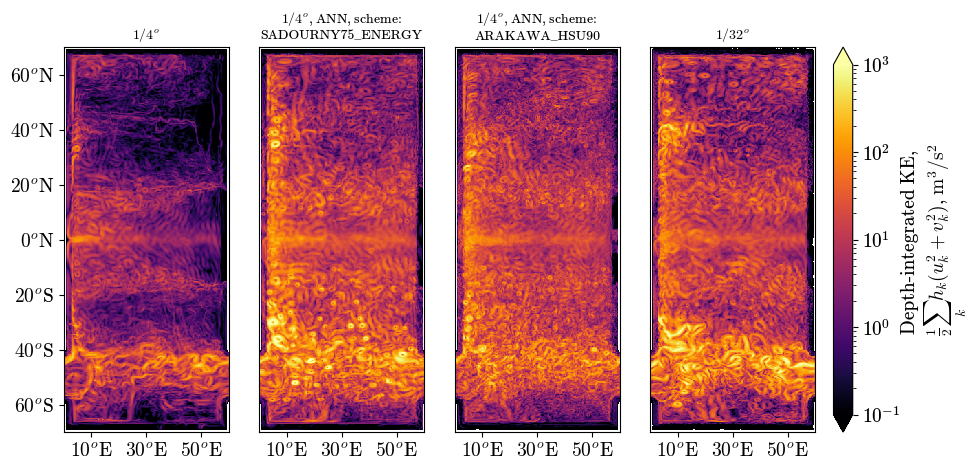

In [20]:
plot(-1)

In [21]:
create_animation_ffmpeg(plot, range(66), filename='ANN_NW2_scheme.mp4', FPS=14)

Native resolution of snapshots is used: 1946x938

Animation ANN_NW2_scheme.mp4 at FPS=14 will last for 4.7 seconds. The frames are saved to 
.ffmpeg/ANN_NW2_scheme



ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

In [32]:
!pip install intake
!pip install intake-xarray
!pip install s3fs

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.9/168.9 kB 29.2 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 46.8 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.10.0
    Uninstalling fsspec-2023.10.0:
      Successfully uninstalled fsspec-2023.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2023.10.0 requires fsspec==2023.10.0, but you have fsspec 2023.12.1 which is incompatible.


In [33]:
from intake import open_catalog
cat = open_catalog('https://raw.githubusercontent.com/ocean-eddy-cpt/cpt-data/master/catalog.yaml')
list(cat)

[autoreload of fsspec.spec failed: Traceback (most recent call last):
  File "/ext3/miniconda3/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/ext3/miniconda3/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 496, in superreload
    update_generic(old_obj, new_obj)
  File "/ext3/miniconda3/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 393, in update_generic
    update(a, b)
  File "/ext3/miniconda3/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 361, in update_class
    update_instances(old, new)
  File "/ext3/miniconda3/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 319, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: can't apply this __setattr__ to _Cached object
]


['neverworld_five_day_averages',
 'neverworld_quarter_degree_snapshots',
 'neverworld_quarter_degree_averages',
 'neverworld_quarter_degree_static',
 'neverworld_quarter_degree_stats',
 'neverworld_eighth_degree_snapshots',
 'neverworld_eighth_degree_averages',
 'neverworld_eighth_degree_static',
 'neverworld_eighth_degree_stats',
 'neverworld_sixteenth_degree_snapshots',
 'neverworld_sixteenth_degree_averages',
 'neverworld_sixteenth_degree_static',
 'neverworld_sixteenth_degree_stats']

In [34]:
cat['neverworld_sixteenth_degree_averages'].to_dask()

AttributeError: module 'fsspec' has no attribute 'core'